# Self supervised learning

In [291]:
import torch
import torch.nn as nn
import numpy as np
import time
import torchvision.transforms.functional as tf

from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, random_split
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomResizedCrop, RandomRotation, \
    RandomAffine, Resize
from matplotlib import pyplot as plt
from random import randint
BATCH_SIZE=64

In [292]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [293]:
transform = Compose([Resize(32), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# FashionMNIST

In [350]:
class FashionMNISTDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index][0]
        target = self.targets[index][1]

        return data, target

In [351]:
root_dir = 'fashion_mnist'
batch_size=64

# Download and load the training data
train_data = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
test_data = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)

In [352]:
def train_val_subset(split):
    data_set = train_data
    nbr_train_examples = int(len(data_set) * split)
    nbr_val_examples = len(data_set) - nbr_train_examples

    return random_split(data_set, [nbr_train_examples, nbr_val_examples])

In [353]:
def train_loader_classification():
    train_subset, val_subset = train_val_subset(0.8)

    train_set = FashionMNISTDataset(
        data=train_subset,
        targets=train_subset
    )
    return DataLoader(train_set, batch_size=16, shuffle=True)

In [354]:
def val_loader_classification():
    train_subset, val_subset = train_val_subset(0.8)

    val_set = FashionMNISTDataset(
        data=val_subset,
        targets=val_subset
    )
    return DataLoader(val_set, batch_size=64, shuffle=False)

In [355]:
def test_loader_classification():
    return DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [356]:
train_loader = train_loader_classification()
val_loader = val_loader_classification()
test_loader = test_loader_classification()

print("Train loader classification")
for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
print("\nVal loader classification")    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break

print("\nTest loader classification")
for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break        

Train loader classification
torch.Size([16, 1, 32, 32]) torch.Size([16])
tensor([1, 2, 2, 7, 3, 0, 8, 2, 7, 4, 8, 1, 4, 7, 9, 1])

Val loader classification
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([3, 8, 3, 8, 0, 6, 4, 8, 2, 6, 5, 2, 7, 1, 7, 5, 7, 9, 7, 4, 2, 1, 1, 3,
        8, 0, 4, 7, 2, 9, 1, 5, 9, 0, 3, 3, 0, 2, 6, 5, 1, 7, 6, 7, 4, 5, 5, 3,
        1, 2, 3, 0, 1, 6, 2, 0, 3, 0, 3, 2, 9, 0, 1, 3])

Test loader classification
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


## Rotation

In [357]:
# Rotate given images by given angle
def rotate(image, angle):
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5, ), (0.5, ))

    return image

In [365]:
for images, labels in train_loader_classification():
    images = images
    labels = labels

    print(images.shape)
    print(labels.shape)
    
    # images_augmented = torch.zeros_like(images)
    # labes_augmented = torch.zeros_like(labels)
    # print(images_augmented.shape)
    # print(labes_augmented.shape)
    images_rotated = []
    labes_rotated = []
    for img in images:
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    
    print(images.shape)
    print(labels.shape)

    
    break


torch.Size([16, 1, 32, 32])
torch.Size([16])
torch.Size([64, 1, 32, 32])
torch.Size([64])


## Exemplar CNN

In [82]:
def horizontal_flip(image):
    transform = Compose([
        RandomHorizontalFlip(p=1.0),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_crop(image):
    transform = Compose([
        RandomCrop((20, 20)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def color_jitter(image):
    transform = Compose([
        ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.02),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_resized_crop(image):
    transform = Compose([
        RandomResizedCrop(50, scale=(0.2, 1.0), ratio=(0.75, 1.333)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_rotation(image):
    transform = Compose([
        RandomRotation(45),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_affine_transformation(image):
    transform = Compose([
        RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.3), shear=10),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img

In [83]:
def random_transform(image):
    transform = ToPILImage()
    img = transform(image)

    transformation = randint(0, 5)

    if transformation == 0:
        return horizontal_flip(img)
    if transformation == 1:
        return random_crop(img)
    if transformation == 2:
        return color_jitter(img)
    if transformation == 3:
        return random_resized_crop(img)
    if transformation == 4:
        return random_rotation(img)
    if transformation == 5:
        return random_affine_transformation(img)

In [84]:
def transform_images(images):
    """Transforms all images of the given batch."""
    for index, img in enumerate(images):
        images[index] = random_transform(img)
    return images

In [85]:
class FashionMNISTExemplarCNNDataset(Dataset):
    """Create FashionMNIST data set for the exemplar cnn task."""

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index][0]
        target = index

        return data, target

In [86]:
def train_data_exemplar_cnn():
    """Creates the train data for the exemplar cnn task."""
    data = train_data

    train_set_exemplar_cnn = FashionMNISTExemplarCNNDataset(
        data=data,
        target=data,
    )

    print('Size of train set for exemplar cnn: {}'.format(len(train_set_exemplar_cnn)))
    return train_set_exemplar_cnn

In [87]:
def test_data_exemplar_cnn():
    """Creates the test data for the rotation task."""
    data = test_data

    test_set_exemplar_cnn = FashionMNISTExemplarCNNDataset(
        data=data,
        target=data,
    )

    print('Size of test set for exemplar cnn: {}'.format(len(test_set_exemplar_cnn)))
    return test_set_exemplar_cnn

In [88]:
def train_loader_exemplar_cnn():
    """Creates the data loader for the exemplar cnn train data."""
    return DataLoader(train_data_exemplar_cnn(), batch_size=64, shuffle=False)

In [89]:
def test_loader_exemplar_cnn():
    """Creates the data loader for the exemplar cnn test data."""
    return DataLoader(test_data_exemplar_cnn(), batch_size=64, shuffle=False)

In [90]:
train_loader = train_loader_exemplar_cnn()
test_loader = test_loader_exemplar_cnn()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break       

Size of train set for exemplar cnn: 60000
Size of test set for exemplar cnn: 10000
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])


Size of train set for exemplar cnn: 60000


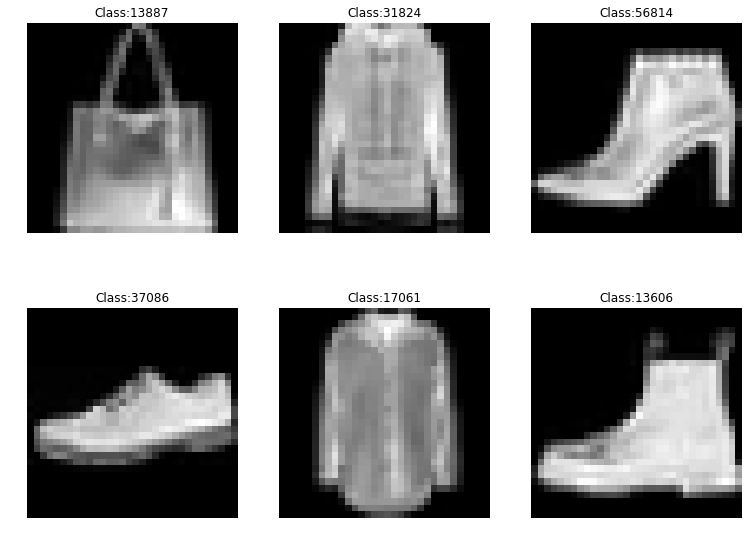

In [91]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data_exemplar_cnn()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

Size of test set for exemplar cnn: 10000


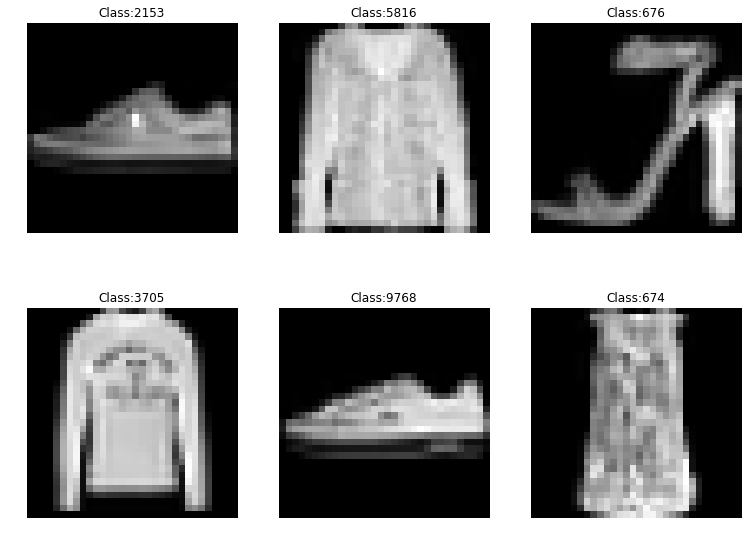

In [92]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data_exemplar_cnn()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

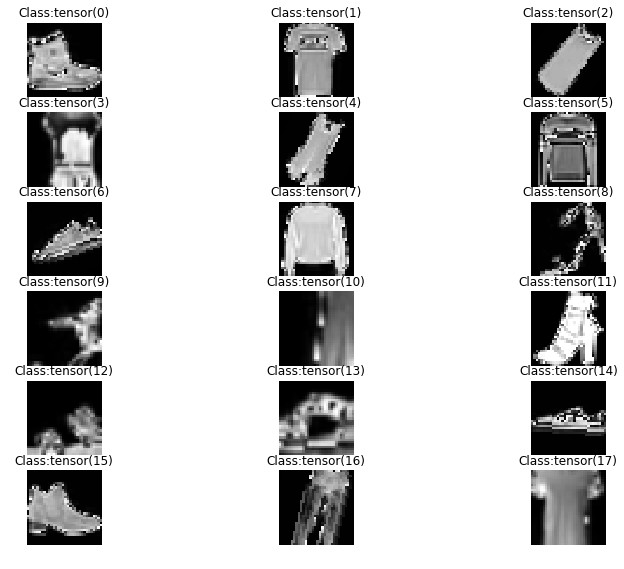

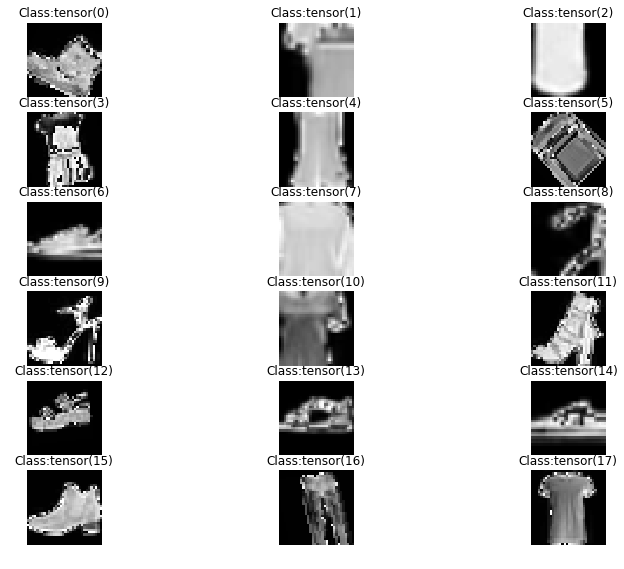

In [93]:
labels_1 = None
transformed_images_1 = None
labels_2 = None
transformed_images_2 = None

for data in train_loader:
    # get the inputs
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # apply random transformation to image, but don't change label
    transformed_images_1 = transform_images(images)
    labels_1 = labels
    break   
    
for data in train_loader:
    # get the inputs
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # apply random transformation to image, but don't change label
    transformed_images_2 = transform_images(images)
    labels_2 = labels
    break     
        
f, axes = plt.subplots(6, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(18):
    index = i
    image = transformed_images_1[index]
    label = labels_1[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')   
    
f, axes = plt.subplots(6, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(18):
    index = i
    image = transformed_images_2[index]
    label = labels_2[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')      

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def plot_n_curves(values, legend,title="n curves graph",  axis1 = "epochs", axis2= "loss/val"):
    """
    Plot n curves in the same graph. use as follows
    
    plot_n_curves([[1,2,3,4,5],[4,5,4,5,4],[2,2,2,2,2]], ["growing", "oscillating", "constant"], title = "3 different curves", axis1 = "epochs", axis2= "loss/val")    
    """
    plt.figure()
    for v in values:
         plt.plot(np.arange(len(v)), v)
    plt.legend(legend)
    plt.xlabel(axis1)
    plt.ylabel(axis2)
    plt.title(title)


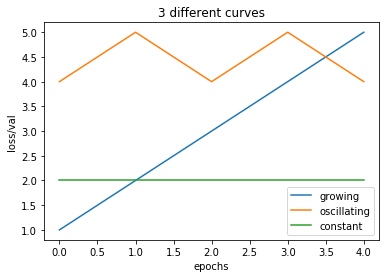

In [95]:
plot_n_curves([[1,2,3,4,5],[4,5,4,5,4],[2,2,2,2,2]], ["growing", "oscillating", "constant"], title = "3 different curves", axis1 = "epochs", axis2= "loss/val")    

## DeepFashion

In [366]:
from torch.utils.data import Dataset

class DeepFashionDataset(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index][0]
        target = self.target[index]

        return datapoint, target

In [367]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import pandas as pd

root_dir = '../img/'
target_size = (32, 32)

def load_images():
    transforms = Compose([
        Resize(target_size),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    return ImageFolder(root_dir, transform=transforms)

In [368]:
def load_list_category_img():
    list_category_img = pd.read_csv('../list_category_img.txt', sep="\t", header=0)
    list_category_img.columns = ["image_name", "category_label"]
    return list_category_img

In [369]:
def load_list_category_cloth():
    list_category_cloth = pd.read_csv('../list_category_cloth.txt', sep="\t", header=0)
    list_category_cloth.columns = ["category_name", "category_type"]
    return list_category_cloth

In [370]:
def load_list_eval_partition():
    list_eval_partition = pd.read_csv('../list_eval_partition.txt', sep="\t", header=0)
    list_eval_partition.columns = ["image_name", "evaluation_status"]
    return list_eval_partition

In [371]:
def train_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    train_indices = partition[partition.evaluation_status == 'train'].index
    train_images = Subset(images, train_indices)
    train_labels = labels.category_label[train_indices].values
    
    return DeepFashionDataset(train_images, train_labels)

In [372]:
def val_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    val_indices = partition[partition.evaluation_status == 'val'].index
    val_images = Subset(images, val_indices)
    val_labels = labels.category_label[val_indices].values
    return DeepFashionDataset(val_images, val_labels)

In [373]:
def test_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    test_indices = partition[partition.evaluation_status == 'test'].index
    test_images = Subset(images, test_indices)
    test_labels = labels.category_label[test_indices].values
    return DeepFashionDataset(test_images, test_labels)

In [374]:
def train_loader():
    return DataLoader(train_data(), batch_size=4, shuffle=True)

In [375]:
loader = train_loader()
print(loader)

In [376]:
def rotate(image, angle):
    """Rotate the image by the specified angle"""
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5,0.5,0.5,), (0.5,0.5,0.5,))
    return image

In [394]:
for images, labels in train_loader():
    images = images
    labels = labels

    print(images.shape)
    print(labels.shape)
    
    images_rotated = []
    labes_rotated = []
    
    for index, img in enumerate(images):
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([index, index, index, index])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(labels)
    print(images.shape)
    print(labels.shape)
    

torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
torch.Size([16])
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
torch.Size([16, 3, 32, 32])
to

KeyboardInterrupt: 

In [106]:
def val_loader():
    return DataLoader(val_data(), batch_size=64, shuffle=False)

In [107]:
def test_loader():
    return DataLoader(test_data(), batch_size=64, shuffle=False)

In [108]:
train_loader_deep_fashion = train_loader()
val_loader_deep_fashion = val_loader()
test_loader_deep_fashion = test_loader()

for xs, ys in train_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break      

torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([41, 39, 16, 17,  3, 26, 41, 41, 18, 33,  3, 19, 18, 17, 18, 18, 44,  3,
        41, 18, 10, 18, 41, 29, 18,  3, 33, 18, 33, 30, 18, 29,  6, 41, 42, 41,
        18, 11, 41, 41, 10, 18, 41, 32, 32, 17, 41, 32, 32, 41, 44,  3, 16, 16,
        41, 17, 18, 18, 41, 19, 41, 41, 16, 41])
torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


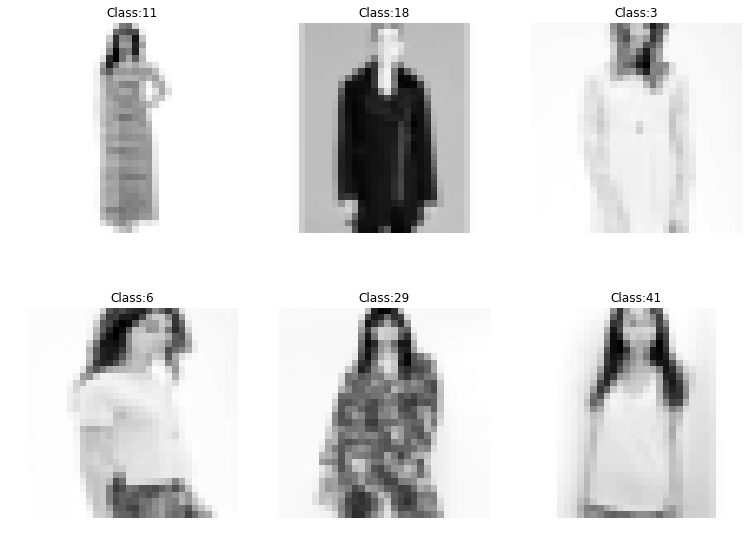

In [109]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

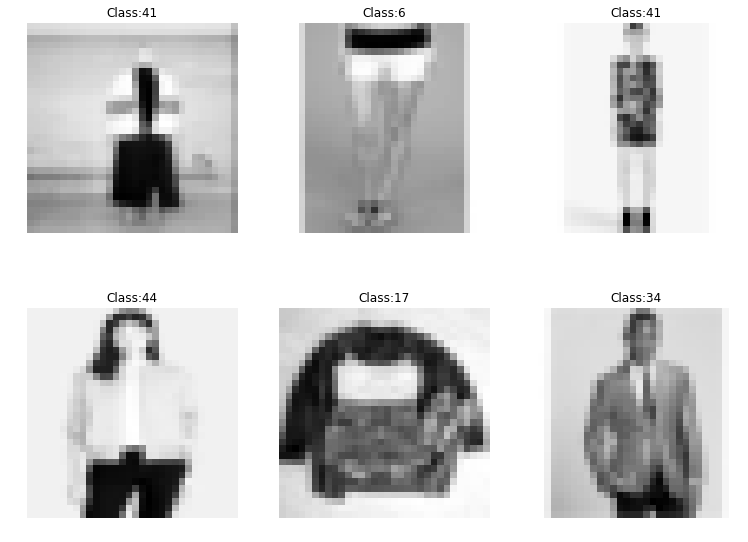

In [110]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

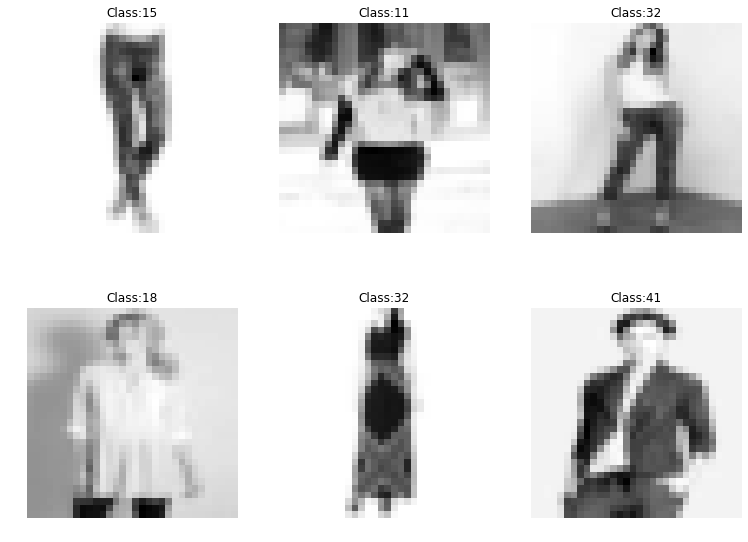

In [111]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

In [112]:
class RotationDataset(Dataset):
    """Create a data set for the rotation task."""

    def __init__(self, data, target, angle):
        self.data = data
        self.target = target
        self.angle = angle

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = rotate(self.data[index][0], self.angle)
        target = None

        if self.angle == 0:
            target = 0
        if self.angle == 90:
            target = 1
        if self.angle == 180:
            target = 2
        if self.angle == 270:
            target = 3

        return data, target


def rotate(image, angle):
    """Rotate the image by the specified angle"""
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5,0.5,0.5,), (0.5,0.5,0.5,))
    return image


In [123]:
data = val_data_rotation_deep_fashion()
print(data)
print(len(data))
index = 159999
if data[index]:
    print("is not in")

160000


IndexError: list index out of range

In [114]:
def train_data_rotation_deep_fashion():
    """Creates the train data for the rotation task."""
    data = train_data()

    train_set_0 = RotationDataset(
        data=data,
        target=data,
        angle=0
    )

    train_set_90 = RotationDataset(
        data=data,
        target=data,
        angle=90
    )

    train_set_180 = RotationDataset(
        data=data,
        target=data,
        angle=180
    )

    train_set_270 = RotationDataset(
        data=data,
        target=data,
        angle=270
    )

    return ConcatDataset([train_set_0, train_set_90, train_set_180, train_set_270])

In [115]:
def train_loader_rotation_deep_fashion():
    """Creates the data loader for the rotation train data."""
    return DataLoader(train_data_rotation_deep_fashion(), batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [116]:
def val_data_rotation_deep_fashion():
    """Creates the validation data for the rotation task."""
    data = val_data()

    val_set_0 = RotationDataset(
        data=data,
        target=data,
        angle=0
    )

    val_set_90 = RotationDataset(
        data=data,
        target=data,
        angle=90
    )

    val_set_180 = RotationDataset(
        data=data,
        target=data,
        angle=180
    )

    val_set_270 = RotationDataset(
        data=data,
        target=data,
        angle=270
    )

    return ConcatDataset([val_set_0, val_set_90, val_set_180, val_set_270])

In [117]:
def val_loader_rotation_deep_fashion():
    """Creates the data loader for the rotation validation data."""
    return DataLoader(val_data_rotation_deep_fashion(), batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [118]:
def test_data_rotation_deep_fashion():
    """Creates the test data for the rotation task."""
    data = test_data()

    test_set_0 = RotationDataset(
        data=data,
        target=data,
        angle=0
    )

    test_set_90 = RotationDataset(
        data=data,
        target=data,
        angle=90
    )

    test_set_180 = RotationDataset(
        data=data,
        target=data,
        angle=180
    )

    test_set_270 = RotationDataset(
        data=data,
        target=data,
        angle=270
    )

    return ConcatDataset([test_set_0, test_set_90, test_set_180, test_set_270])

In [119]:
def test_loader_rotation_deep_fashion():
    """Creates the data loader for the rotation test data."""
    return DataLoader(test_data_rotation_deep_fashion(), batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [120]:
train_loader_rotation_deep_fashion = train_loader_rotation_deep_fashion()
val_loader_rotation_deep_fashion = val_loader_rotation_deep_fashion()
test_loader_rotation_deep_fashion = test_loader_rotation_deep_fashion()

for xs, ys in train_loader_rotation_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader_rotation_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader_rotation_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break         

torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([2, 3, 3, 3, 0, 0, 0, 3, 3, 1, 2, 1, 1, 3, 0, 3, 1, 2, 1, 3, 1, 2, 0, 0,
        3, 1, 2, 0, 2, 1, 1, 1, 3, 2, 3, 1, 0, 1, 1, 3, 3, 2, 2, 1, 3, 0, 2, 3,
        0, 0, 2, 0, 1, 0, 3, 2, 2, 2, 2, 2, 2, 0, 2, 1])
torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


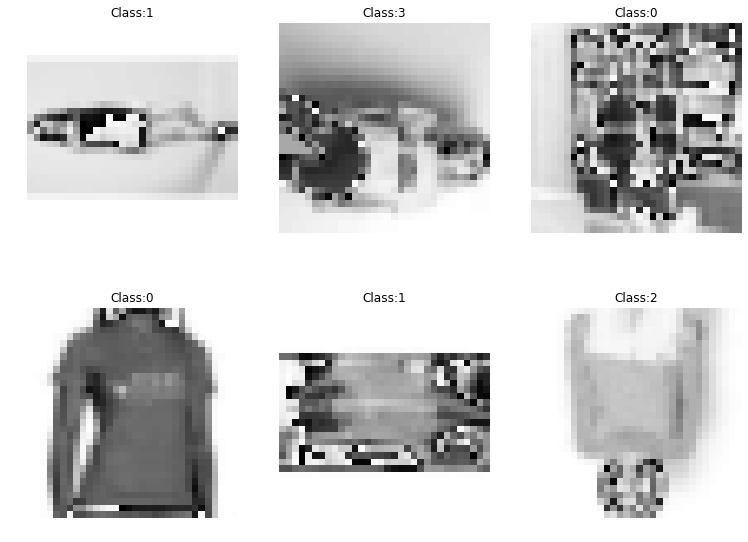

In [74]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data_rotation_deep_fashion()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

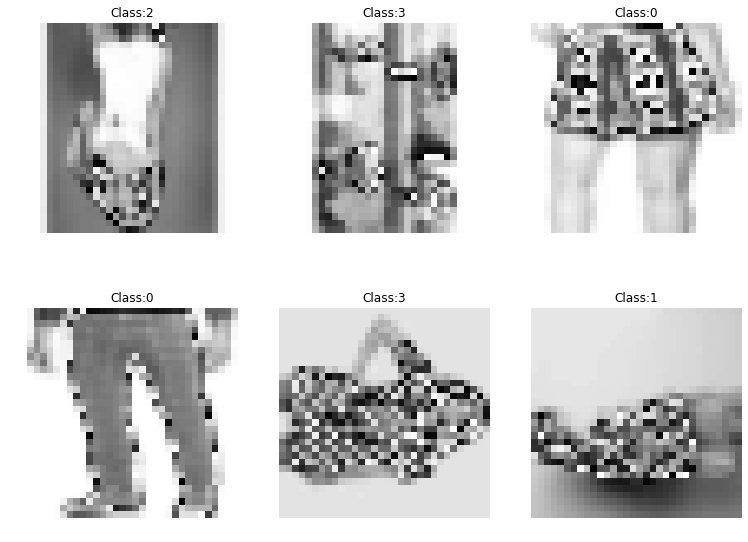

In [76]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data_rotation_deep_fashion()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

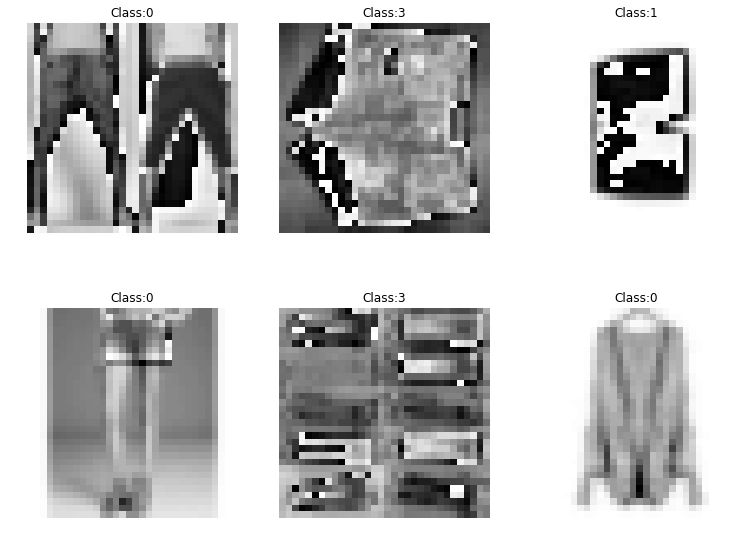

In [77]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data_rotation_deep_fashion()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  